In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle

In [2]:
df = pd.read_csv('data_model.csv')
df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,Market Value,Market Value Euros
0,1,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,2000,20,19,...,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,€11.00m,11000000.0
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,22,22,...,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,€600k,600000.0
2,3,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,1999,14,8,...,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,€4.00m,4000000.0
3,4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,20,20,...,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,€8.00m,8000000.0
4,5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1993,15,15,...,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,€2.50m,2500000.0


In [3]:
missing = df.isnull().sum()
missing

Rk                    0
Player                0
Nation                0
Pos                   0
Squad                 0
Comp                  0
Age                   0
Born                  0
MP                    0
Starts                0
Min                   0
90s                   0
SoT                   0
G/SoT                 0
PKatt                 0
PPA                   0
CrsPA                 0
TB                    0
Sw                    0
TI                    0
CK                    0
SCA                   0
GCA                   0
Tkl                   0
Blocks                0
Int                   0
Tkl+Int               0
Clr                   0
Err                   0
Touches               0
Carries               0
CPA                   0
Rec                   0
CrdY                  0
CrdR                  0
2CrdY                 0
Fls                   0
Fld                   0
Off                   0
Crs                   0
TklW                  0
PKwon           

In [4]:
df['log_target'] = np.log1p(df['Market Value Euros'])

In [5]:
# this is clean notebook, so I have already selected most important features
important_features = [
    'Age', 'Min', 'Starts', '90s', 'MP',
    'CPA', 'Rec', 'G/SoT', 'GCA', 'Carries',
    'SoT', 'SCA', 'Touches', 'PPA'
]

In [6]:
correlations = df[important_features + ['log_target']].corr()['log_target'].sort_values(ascending=False)
correlations

log_target    1.000000
Min           0.322494
90s           0.322463
Starts        0.319825
MP            0.313081
Rec           0.201074
G/SoT         0.174361
CPA           0.170665
Carries       0.165903
GCA           0.157532
SCA           0.146132
Touches       0.129098
SoT           0.100039
PPA           0.089147
Age          -0.315186
Name: log_target, dtype: float64

In [7]:
X = df[important_features]
y = df['log_target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = RandomForestRegressor(
                            n_estimators=150,
                            max_depth=15,
                            min_samples_split=5,
                            min_samples_leaf=2,
                            random_state=42)

In [9]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=150, random_state=42)

In [10]:
y_pred = model.predict(X_test)

In [11]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [12]:
print(f"rmse: {rmse:.4f}")
print(f"mae: {mae:.4f}")
print(f"R2: {r2:.4f}")

rmse: 1.1234
mae: 0.9059
R2: 0.4023


In [13]:
# since I have used log transformation to train this model we need to conver predicted and test data back to original scale
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

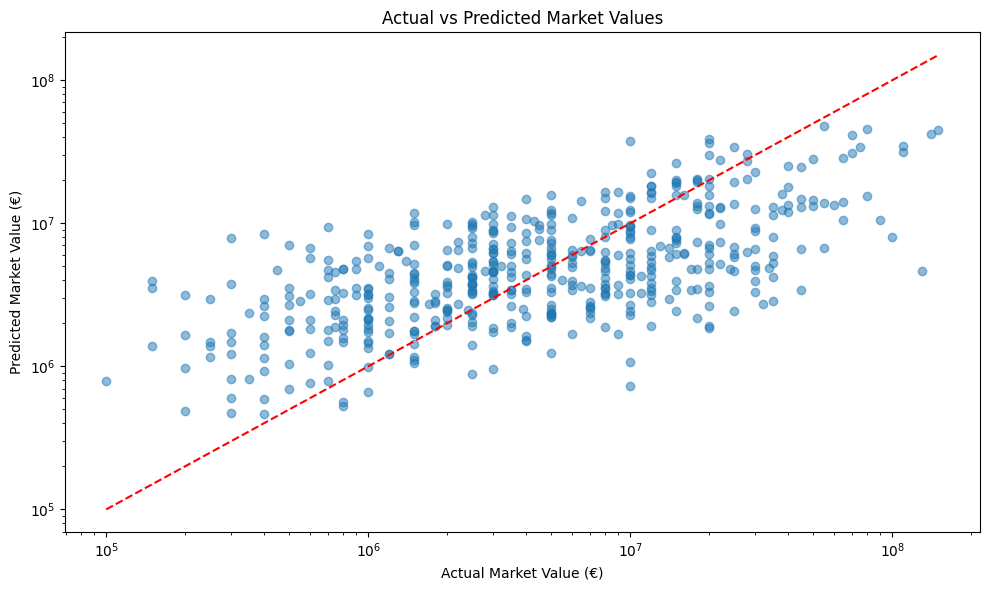

In [14]:
# you can use this graph on your presentation to ilustrate the line of best fit for this model and explain a bit
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)], 'r--')
plt.xlabel('Actual Market Value (€)')
plt.ylabel('Predicted Market Value (€)')
plt.title('Actual vs Predicted Market Values')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

In [15]:
feature_importance = pd.DataFrame({
    'Feature': important_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
feature_importance

,Feature,Importance
0,Age,0.248975
1,Min,0.139466
6,Rec,0.119741
12,Touches,0.066456
9,Carries,0.059629
11,SCA,0.057761
10,SoT,0.054200
4,MP,0.047981
5,CPA,0.046628
13,PPA,0.034964


In [16]:
# here just saving a model Luke please run this so model will be dowloaded on your machine just using pkl library to make it faster
with open('player_value_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# bello is just exploration that you can include in your analysis

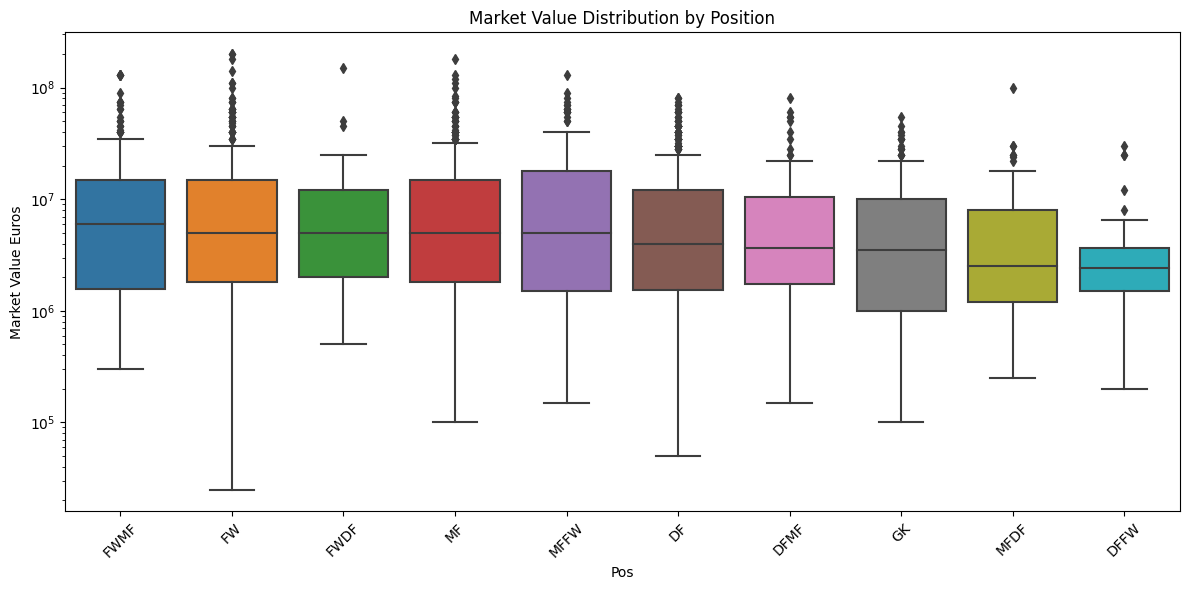

In [17]:
# here is very interesing because like age you know how impirtant this is so I have descided to include it maybe you can add this to your presentation and
# talk more about it

plt.figure(figsize=(12, 6))
pos_order = df.groupby('Pos')['Market Value Euros'].median().sort_values(ascending=False).index
sns.boxplot(x='Pos', y='Market Value Euros', data=df, order=pos_order)
plt.title('Market Value Distribution by Position')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()

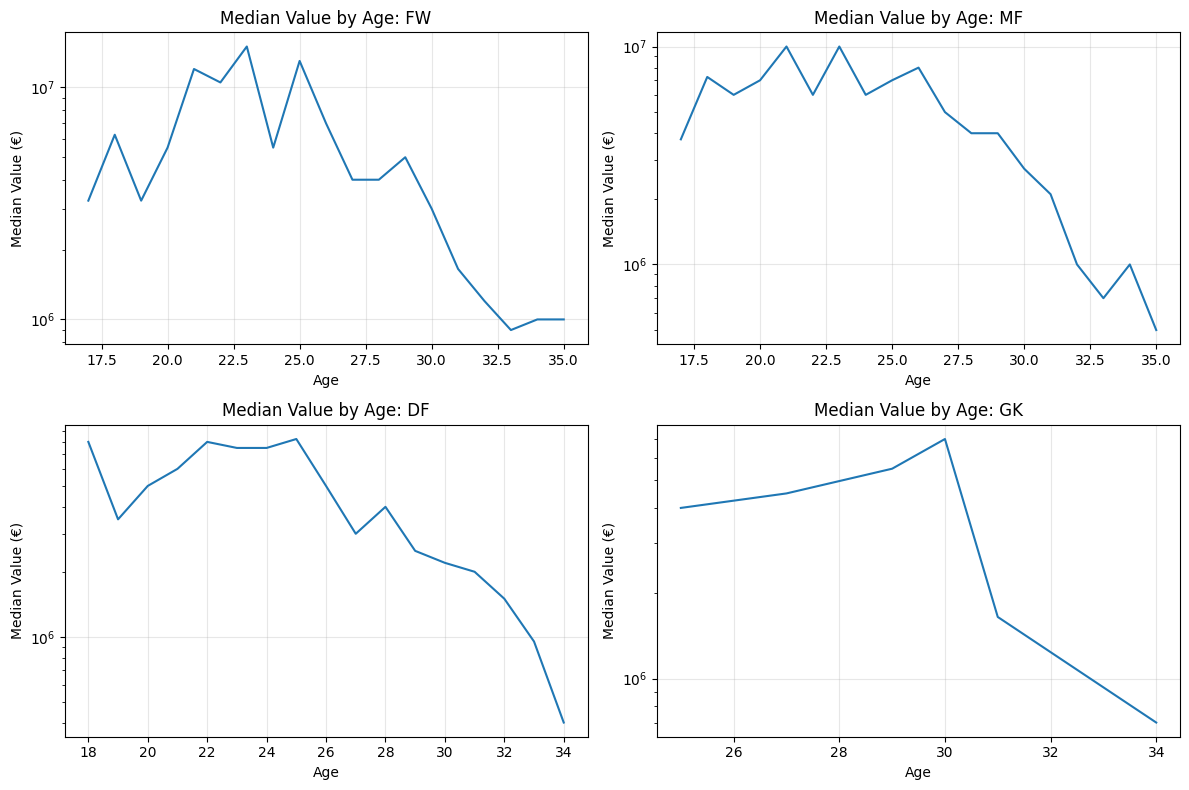

In [18]:
# since we had positions I have also descided to focus and emphasise this since we all know how for different position prices is going down when they become older

positions = ['FW', 'MF', 'DF', 'GK']
plt.figure(figsize=(12, 8))

for i, pos in enumerate(positions):

    pos_data = df[df['Pos'].str.contains(pos)]
    if len(pos_data) > 0:
        age_data = pos_data.groupby('Age')['Market Value Euros'].median()
        age_data = age_data[pos_data.groupby('Age').size() > 10]
        plt.subplot(2, 2, i+1)
        plt.plot(age_data.index, age_data.values)
        plt.title(f'Median Value by Age: {pos}')
        plt.xlabel('Age')
        plt.ylabel('Median Value (€)')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)

plt.tight_layout()